In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import plotly.plotly as py
import plotly.tools as tls
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

In [2]:
df_test = pd.read_csv('churn_test.csv')
df_train = pd.read_csv('churn_train.csv')

# Exploratory Data Analysis (EDA)

In [3]:
print "The number of training data is %d" %(df_train.shape[0])
print "The number of test data is %d" %(df_test.shape[0])
print "Training data : Test date = %d%% : %d%%" \
%(float(len(df_train))/(len(df_train) + len(df_test))*100, \
  float(len(df_test))/(len(df_train) + len(df_test))*100)

The number of training data is 40000
The number of test data is 10000
Training data : Test date = 80% : 20%


In [4]:
df_train.shape

(40000, 12)

In [5]:
df_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null object
phone                     39681 non-null object
signup_date               40000 non-null object
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 3.4+ MB


In [8]:
df_train.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,40000.000000,39838.000000,33472.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,5.791302,4.777434,4.601697,1.074956,8.857342,2.280700,60.874382
std,5.708056,0.448088,0.614810,0.222427,20.014008,3.811289,37.089619
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.930000,5.000000,5.000000,1.050000,8.300000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [9]:
def check_null(df):
    count_nan = len(df) - df.count()
    print "The null ratio in PERCENTAGE (%):"
    print (count_nan)/len(df)*100

In [10]:
check_null(df_train)

The null ratio in PERCENTAGE (%):
avg_dist                   0.0000
avg_rating_by_driver       0.4050
avg_rating_of_driver      16.3200
avg_surge                  0.0000
city                       0.0000
last_trip_date             0.0000
phone                      0.7975
signup_date                0.0000
surge_pct                  0.0000
trips_in_first_30_days     0.0000
luxury_car_user            0.0000
weekday_pct                0.0000
dtype: float64


In [11]:
last_date = pd.to_datetime(df_train['last_trip_date'])
last_date_max_global = last_date.max()
print last_date_max_global

2014-07-01 00:00:00


# Data Engineering

## Add one lable column df['Churn?'] based on the difference of the last data wrt the pull date 07/01/2014: 1 means churn (diff > 30); 0 means active

In [12]:
def add_churn_column(df):
    last_date = pd.to_datetime(df['last_trip_date'])
    last_date_diff = (last_date_max_global - last_date)/np.timedelta64(1, 'D')
#     print last_date_diff 
    df['Churn?'] =  (last_date_diff > 30) * 1

## Convert column['phone'], whose original values are "iphone/Android", to binary 0/1. Due to small percentage of null values(0.8%), null values are randomly replaced with 0 or 1 based on the ratio of iphone/Android.

In [13]:
ipercent = len(df_train[df_train['phone']=='iPhone'])/float(len(df_train))
def phone_binary(df):    
    b_loon = {'iPhone':0,'Android':1}
    df['phone'] = df['phone'].map(b_loon)
    df['phone'].fillna(np.random.choice(2, p = [ipercent,1-ipercent]), inplace=True)

## Fill null in column ['avg_rating_by_driver'] and ['avg_rating_of_driver'] with average values

In [14]:
def ave_rates(df):
    for rating in ['avg_rating_by_driver', 'avg_rating_of_driver']:
        meanl = []
        for city in ['Astapor','Winterfell', "King's Landing"]:        
            test = df_train[df_train['city'] == city][rating]
            test2 = test[~np.isnan(test)]
            mean_val = test2.median()
            meanl.append(mean_val)
        mean_val2 = np.array(meanl).mean()
        df[rating].fillna(mean_val2, inplace=True)

## Convert column['luxury_car_user'] True/False to 1/0

In [15]:
def luxury(df):
    df['luxury_car_user'] = (df['luxury_car_user'] == True) * 1

## Add dummy columns for ['city'] and remove column ['city']

In [16]:
def city_cat(df):
    dummies = pd.get_dummies(df['city'], drop_first=True)
    df = df.join(dummies)
    del df['city']
    return df

# Apply data engineering to both training and test data

In [17]:
add_churn_column(df_train)
add_churn_column(df_test)

In [18]:
phone_binary(df_train)
phone_binary(df_test)

In [19]:
ave_rates(df_train)
ave_rates(df_test)

In [20]:
luxury(df_test)
luxury(df_train)

In [21]:
df_train = city_cat(df_train)
df_test = city_cat(df_test)

# Delete column ['last_trip_date'] and ['signup_date'] to avoid data leakage

In [22]:
del df_train['last_trip_date']
del df_train['signup_date']
del df_test['last_trip_date']
del df_test['signup_date']

In [23]:
check_null(df_test)

The null ratio in PERCENTAGE (%):
avg_dist                  0.0
avg_rating_by_driver      0.0
avg_rating_of_driver      0.0
avg_surge                 0.0
phone                     0.0
surge_pct                 0.0
trips_in_first_30_days    0.0
luxury_car_user           0.0
weekday_pct               0.0
Churn?                    0.0
King's Landing            0.0
Winterfell                0.0
dtype: float64


In [24]:
df_train.shape

(40000, 12)

## Make a copy of dataset with lable column['Churn?']

In [25]:
df_train_bu = df_train.copy()
df_test_bu = df_test.copy()

In [26]:
df_train_bu.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,phone,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,Churn?,King's Landing,Winterfell
0,6.94,5.0,5.000000,1.00,1.0,0.0,0,0,100.0,1,0,0
1,8.06,5.0,5.000000,1.00,1.0,0.0,2,1,0.0,1,0,0
2,21.50,4.0,4.933333,1.00,0.0,0.0,1,1,100.0,1,0,1
3,9.46,5.0,4.933333,2.75,1.0,100.0,1,0,100.0,1,0,1
4,13.77,5.0,4.933333,1.00,0.0,0.0,0,0,100.0,1,0,1


# Random Forest 
## Feature importance

In [27]:
y_train = df_train.pop('Churn?')
x_train = df_train.values
y_test  = df_test.pop('Churn?')
x_test  = df_test.values
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [28]:
feature_list = df_train.columns.values

In [29]:
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(x_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f): %s" % (f + 1, indices[f], importances[indices[f]], \
                                       feature_list[f]))



/Users/miyan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Feature ranking:
1. feature 0 (0.284057): avg_dist
2. feature 8 (0.152851): avg_rating_by_driver
3. feature 6 (0.097910): avg_rating_of_driver
4. feature 1 (0.096452): avg_surge
5. feature 2 (0.090038): phone
6. feature 5 (0.068584): surge_pct
7. feature 9 (0.065495): trips_in_first_30_days
8. feature 3 (0.053729): luxury_car_user
9. feature 4 (0.043670): weekday_pct
10. feature 7 (0.036715): King's Landing
11. feature 10 (0.010498): Winterfell


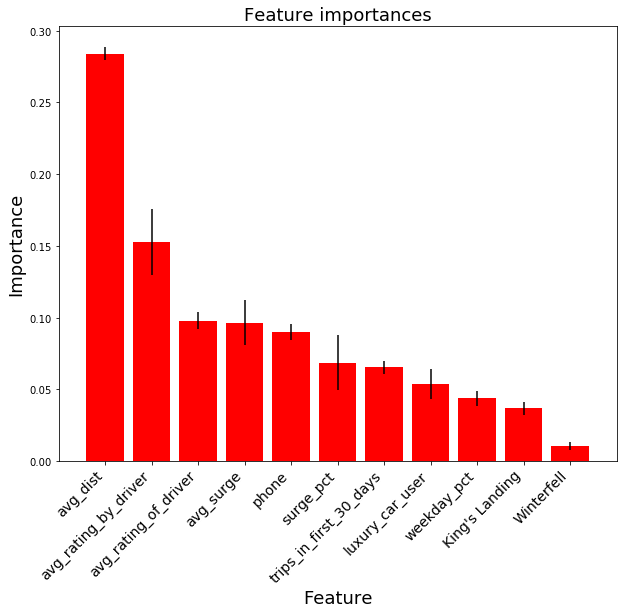

In [30]:
# Plot the feature importances of the forest
mpl_fig = plt.figure(figsize=(10, 8))
ax = mpl_fig.add_subplot(111)
# plt.figure()
ax.set_title("Feature importances", fontsize=18)
ax.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
ax.set_xticks(range(x_train.shape[1]))
ax.set_xlim([-1, x_train.shape[1]])
ax.set_xlabel("Feature", fontsize=18)
ax.set_ylabel("Importance", fontsize=18)
ax.set_xticklabels((feature_list), rotation=45, fontsize=14, ha = 'right')
plt.show()

## Let's study the most important feature "avg_dist"

In [31]:
train_avg_dist_churn = df_train_bu[df_train_bu["Churn?"] == 1.0]['avg_dist']
train_avg_dist_activ = df_train_bu[df_train_bu["Churn?"] == 0]['avg_dist']
print train_avg_dist_churn.shape
print train_avg_dist_activ.shape

(24968,)
(15032,)


In [32]:
num_set = 30
for i in xrange(num_set):
    if i == 0:        
        num_churn = [float(len(train_avg_dist_churn[train_avg_dist_churn < 1]))]
        num_activ = [float(len(train_avg_dist_activ[train_avg_dist_activ < 1]))]
    elif i != (num_set - 1):
        num_churn.append(float(len(train_avg_dist_churn[(train_avg_dist_churn < (i + 1)) &\
                                                 (train_avg_dist_churn >= i)])))
        num_activ.append(float(len(train_avg_dist_activ[(train_avg_dist_activ < (i + 1)) &\
                                                 (train_avg_dist_activ >= i)])))
    else:
        num_churn.append(float(len(train_avg_dist_churn[(train_avg_dist_churn >= (i))])))
        num_activ.append(float(len(train_avg_dist_activ[(train_avg_dist_activ >= (i))])))

In [33]:
num_churn_pct = list(np.array(num_churn)/(np.array(num_churn) + np.array(num_activ)))
num_activ_pct = list(np.array(num_activ)/(np.array(num_churn) + np.array(num_activ)))

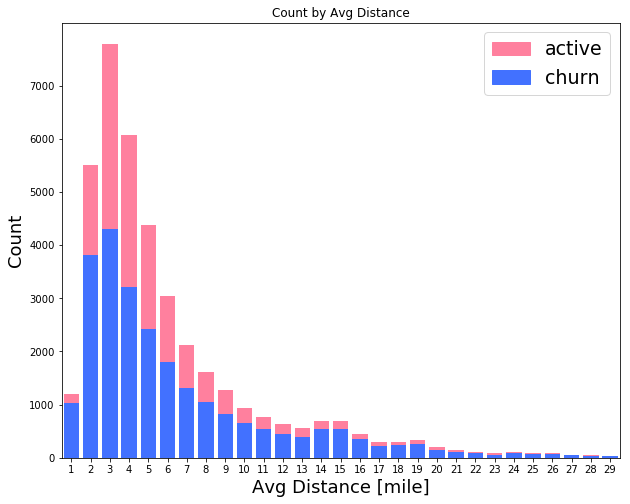

In [34]:
mpl_fig = plt.figure(figsize=(10, 8))
ax = mpl_fig.add_subplot(111)

N = len(num_activ)

ind = np.arange(N)    # the x locations for the groups
width = 0.8       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind[:-1], num_churn[:-1], width, color=(0.2588,0.4433,1.0))
p2 = ax.bar(ind[:-1], num_activ[:-1], width, color=(1.0,0.5,0.62), bottom=num_churn[:-1])
ax.set_ylabel('Count', fontsize = 18)
ax.set_xlabel('Avg Distance [mile]', fontsize = 18)
ax.set_title('Count by Avg Distance')

ax.set_xticks(np.arange(0, num_set-1, 1))
ax.set_yticks(np.arange(0, 8000, 1000))
ax.set_xticklabels((xrange(1,N)))
ax.set_xlim([-0.5, num_set-1.5])

red_patch = mpatches.Patch(color=(1.0,0.5,0.62), label='active')
blue_patch = mpatches.Patch(color=(0.2588,0.4433,1.0), label='churn')
ax.legend(handles=[red_patch, blue_patch], prop={'size':19})

plt.show()

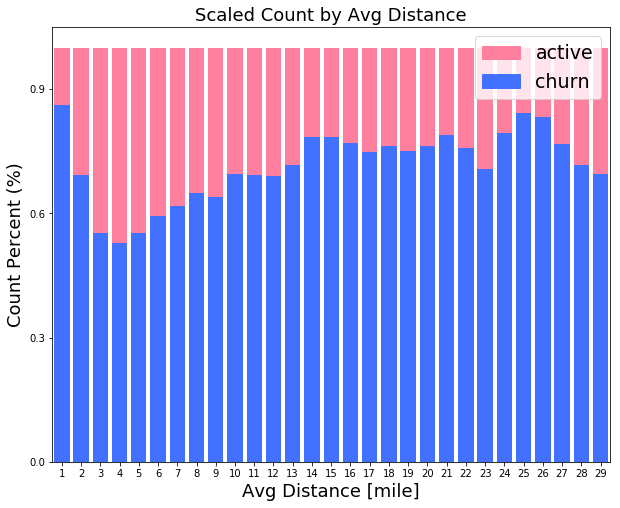

In [35]:

mpl_fig = plt.figure(figsize=(10, 8))
ax = mpl_fig.add_subplot(111)

N = len(num_activ)
# num_churn = (20, 35, 30, 35, 27)
# num_activ = (25, 32, 34, 20, 25)
ind = np.arange(N)    # the x locations for the groups
width = 0.8       # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind[:-1], num_churn_pct[:-1], width, color=(0.2588,0.4433,1.0))
p2 = ax.bar(ind[:-1], num_activ_pct[:-1], width, color=(1.0,0.5,0.62),
             bottom=num_churn_pct[:-1])
ax.set_ylabel('Count Percent (%)', fontsize = 18)
ax.set_xlabel('Avg Distance [mile]', fontsize = 18)
ax.set_title('Scaled Count by Avg Distance', fontsize = 18)

ax.set_xticks(np.arange(0, num_set-1, 1))
ax.set_yticks(np.arange(0, 1.2, 0.3))
ax.set_xticklabels((xrange(1,N)))
ax.set_xlim([-0.5, num_set-1.5])

red_patch = mpatches.Patch(color=(1.0,0.5,0.62), label='active')
blue_patch = mpatches.Patch(color=(0.2588,0.4433,1.0), label='churn')
ax.legend(handles=[red_patch, blue_patch], prop={'size':19})

plt.show()

## Model fitting

In [47]:
coarse_RF_search = RandomForestClassifier(n_estimators = 200, n_jobs=-1)
param_grid = {'max_features':[2, 3, 4, 5],  #suggested value is sqrt(number of features, 11 here) 
       'min_samples_leaf':[10, 20, 30, 40]}
GS_search = GridSearchCV(estimator=coarse_RF_search, param_grid = param_grid, cv=5)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best coarse params: %s " % GS_search.best_params_

Best coarse params: {'max_features': 3, 'min_samples_leaf': 10} 


In [48]:
fine_RF_search = RandomForestClassifier(n_estimators = 200, n_jobs=-1)
param_grid = {'max_features':[3],  #suggested value is sqrt(number of features, 11 here) 
       'min_samples_leaf':[6, 8, 10, 12, 14]}
GS_search = GridSearchCV(estimator=fine_RF_search, param_grid = param_grid, cv=5)
y_train=y_train.reshape(-1,)
GS_search.fit(x_train,y_train)
print "Best fine params: %s " % GS_search.best_params_

Best fine params: {'max_features': 3, 'min_samples_leaf': 14} 


In [50]:
def oob_error_plot(n_estimator_begin, n_estimator_end, step = 2):
    oob_error = []
    test_error = []
    for i in xrange(n_estimator_begin, n_estimator_end, step):
        rf = RandomForestClassifier(n_estimators=i, 
                                    n_jobs=-1, 
                                    oob_score=True,
                                    max_features = 3,
                                    min_samples_leaf = 14)
        rf.fit(x_train, y_train)
        oob_error_temp = 1 - rf.oob_score_
        test_error_temp = 1- rf.score(x_test, y_test)
        oob_error.append(oob_error_temp)
        test_error.append(test_error_temp)
    
    mpl_fig = plt.figure(figsize=(6, 4))
    plt.plot(range(n_estimator_begin, n_estimator_end, step), oob_error, \
           color="r")
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.show()

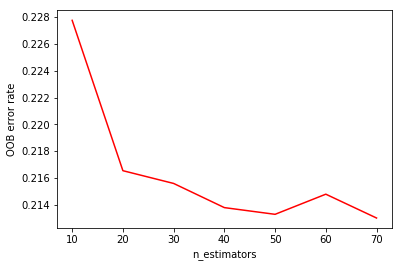

In [51]:
oob_error_plot(10,80,10)

## Conclusion: select number of trees = 50

In [52]:
RF_final = RandomForestClassifier(n_estimators = 50, n_jobs=-1, oob_score=True,
                              max_features=3, min_samples_leaf=14)

# Final model and metric

In [53]:
RF_final.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=14,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [54]:
print "Accuracy score:  ", RF_final.score(x_test, y_test)
print "Out of bag score:", RF_final.oob_score_
y_predict = RF_final.predict(x_test)
print 'Precision:       ', precision_score(y_test, y_predict)
print 'Recall:          ', recall_score(y_test, y_predict)

Accuracy score:   0.7777
Out of bag score: 0.78595
Precision:        0.79609640692
Recall:           0.86448298009


In [55]:
confu_mat = confusion_matrix(y_test, y_predict)

In [45]:
print 'Confution Matrix'
print ' --------------------------------------------------'
print '|               | Pred Churn (1) | Pred Active (0) |'
print ' --------------------------------------------------'
print '| Act Churn (1) |      %d      |       %d       |' %(confu_mat[1,1], confu_mat[1, 0])
print '| Act Active(0) |      %d      |       %d      |' %(confu_mat[0,1], confu_mat[0, 0])
print ' --------------------------------------------------'

Confution Matrix
 --------------------------------------------------
|               | Pred Churn (1) | Pred Active (0) |
 --------------------------------------------------
| Act Churn (1) |      5389      |       839       |
| Act Active(0) |      1373      |       2399      |
 --------------------------------------------------


## ROC curve

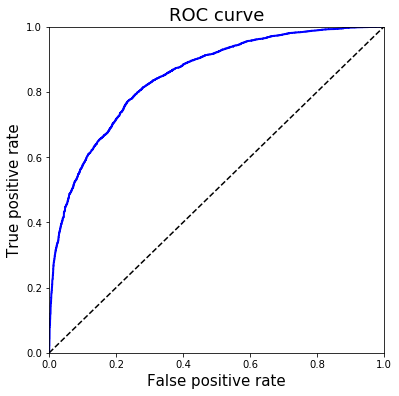

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, RF_final.predict_proba(x_test)[:,1])
roc_auc = auc(fpr, tpr)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1,1,1)

ax.plot(fpr, tpr, lw=2, c='b')
ax.plot([0 ,1], [0, 1], 'k--')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('False positive rate', fontsize = 15)
ax.set_ylabel('True positive rate', fontsize = 15)
ax.set_title('ROC curve', fontsize = 18)
plt.show()